In [ ]:
import gzip
import shutil
import os

!wget -nc http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget -nc http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!wget -nc http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget -nc http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

# Unzip the downloaded files
!gunzip -k train-images-idx3-ubyte.gz
!gunzip -k train-labels-idx1-ubyte.gz
!gunzip -k t10k-images-idx3-ubyte.gz
!gunzip -k t10k-labels-idx1-ubyte.gz

--2024-09-11 19:22:47--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.169.4, 52.219.171.228, 3.5.134.14, ...
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.169.4|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]  25.20M  98.8MB/s    in 0.3s    

2024-09-11 19:22:47 (98.8 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [26421880/26421880]

--2024-09-11 19:22:47--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.169.4, 52.219.171.228, 3.5.134.1

In [ ]:
import struct
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split, TensorDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from itertools import product
# Helper function to read IDX files
def read_idx(file_path):
    with open(file_path, 'rb') as f:
        magic_number, size = struct.unpack('>II', f.read(8))
        if magic_number == 2051:  # 2051 code for images
            rows, cols = struct.unpack('>II', f.read(8))
            data = np.fromfile(f, dtype=np.uint8).reshape(size, rows, cols)
        elif magic_number == 2049:  # 2049 code for labels
            data = np.fromfile(f, dtype=np.uint8)
        else:
            raise ValueError('Invalid IDX file')
    return data

# Load images and labels
full_train_images = read_idx('train-images-idx3-ubyte')
full_train_labels = read_idx('train-labels-idx1-ubyte')

test_images = read_idx('t10k-images-idx3-ubyte')
test_labels = read_idx('t10k-labels-idx1-ubyte')

# Convert images and labels to PyTorch tensors
full_train_images = torch.tensor(full_train_images, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
full_train_labels = torch.tensor(full_train_labels, dtype=torch.long)

test_images = torch.tensor(test_images, dtype=torch.float32).unsqueeze(1)
test_labels = torch.tensor(test_labels, dtype=torch.long)

# Split into train and validation sets
val_size = 5000  # Define size of validation set
train_size = len(full_train_images) - val_size
train_images, val_images = random_split(TensorDataset(full_train_images, full_train_labels), [train_size, val_size])


In [ ]:
# Transformations for LeNet-5
transform = transforms.Compose([
    transforms.Pad(2),                 # Pad 28x28 to 32x32
    transforms.Normalize((0.5,), (0.5,))  # Normalize to range [-1, 1]
])

# Apply the transformation during data loading
def apply_transform(dataset):
    images, labels = zip(*[(transform(image), label) for image, label in dataset])
    return TensorDataset(torch.stack(images), torch.tensor(labels))

train_images = apply_transform(train_images)
val_images = apply_transform(val_images)
test_dataset = apply_transform(TensorDataset(test_images, test_labels))
# Create DataLoaders
train_loader = DataLoader(train_images, batch_size=64, shuffle=True)
val_loader = DataLoader(val_images, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

**Functions for training one epoch, evaluating a model, plotting train/test accuracy vs epoch, and tuning hyperparameters for best fitted model**

Training one epoch

In [ ]:
### using the cpu from google environment or optionally GPU for computation related to training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
### Training one epoch / iteration of weight updates
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

Evaluating a model

In [ ]:
### Evaluate model
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

plot function of accuracy vs epochs

In [ ]:
### Plotting accuracy as a function of training epoch
def plot_accuracies(train_accuracies, test_accuracies, title='Accuracy vs. Epochs'):
    num_epochs = min(len(train_accuracies), len(test_accuracies))  # min used to ensure print in case of inconsistencies
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_accuracies[:num_epochs], label='Training Accuracy', marker='o')
    plt.plot(epochs, test_accuracies[:num_epochs], label='Test Accuracy', marker='o')
    plt.title(title)  # Use the provided title
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

Tuning Hyperparameters of a given model

In [ ]:
def tune_hyperparameters(
    model_fn,  ### Callable for new model for each iteration
    train_loader,
    val_loader,
    test_loader,
    device,
    num_epochs=10,
    batch_sizes=[32, 64, 128],
    learning_rates=[0.1, 0.01, 0.001],
    optimizers=['SGD', 'Adam'],
    dropout_rates=None,
    weight_decay_rates=None,
    title='Accuracy vs. Epochs'
):
    if dropout_rates is None:
        dropout_rates = [0.0]  ### Default to no dropout
    if weight_decay_rates is None:
        weight_decay_rates = [0.0]  ### Default to no weight decay

    best_acc = 0.0
    best_params = None
    best_model = None
    best_train_accuracies = []
    best_test_accuracies = []

    total_combinations = (len(batch_sizes) * len(learning_rates) * len(optimizers) *
                          len(dropout_rates) * len(weight_decay_rates))
    round_counter = 1

    for batch_size, lr, opt, dropout_rate, weight_decay in product(batch_sizes, learning_rates, optimizers, dropout_rates, weight_decay_rates):
        print(f"Round {round_counter}/{total_combinations}: Tuning with batch_size={batch_size}, learning_rate={lr}, optimizer={opt}, dropout_rate={dropout_rate}, weight_decay={weight_decay}")
        round_counter += 1

        ### Initialize a new, fresh model
        if dropout_rate > 0:
            model = model_fn(dropout_rate).to(device)
        else:
            model = model_fn().to(device)

        criterion = nn.CrossEntropyLoss()

        if opt == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif opt == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        train_accuracies = []
        val_accuracies = []
        test_accuracies = []
        best_epoch_model = None

        for epoch in range(num_epochs):
            # Training phase (dropout active)
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

            # Validation and Test phase (dropout deactivated)
            model.eval()  # Deactivate dropout
            val_loss, val_acc = evaluate(model, val_loader, criterion, device)
            test_loss, test_acc = evaluate(model, test_loader, criterion, device)
            model.train()  # Reactivate dropout for the next training epoch

            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)

            print(f"Epoch [{epoch+1}/{num_epochs}], Train Acc: {train_acc:.2f}, Val Acc: {val_acc:.2f}, Test Acc: {test_acc:.2f}")

            ### Save the best model based on validation accuracy
            if val_acc > best_acc:
                best_acc = val_acc
                best_params = {'batch_size': batch_size, 'learning_rate': lr, 'optimizer': opt,
                               'dropout_rate': dropout_rate, 'weight_decay': weight_decay}
                best_epoch_model = model.state_dict()

                # Keeping track of these for plotting
                best_train_accuracies = train_accuracies.copy()
                best_val_accuracies = val_accuracies.copy()
                best_test_accuracies = test_accuracies.copy()

        ### Save/update the best model from the current hyperparameter setting
        if best_epoch_model:
            best_model = model_fn(dropout_rate).to(device) if dropout_rate > 0 else model_fn().to(device)
            best_model.load_state_dict(best_epoch_model)
            print(f"New best model found with Val Acc: {best_acc:.2f}")

    print(f"Best Model Parameters: {best_params} with Validation Accuracy: {best_acc:.2f}")

    ### Ensuring that both accuracy lists are of same length, else will take min length to ensure plot can still be printed
    if len(best_train_accuracies) != len(best_test_accuracies):
        print("Warning: Train and test accuracies lists are of unequal lengths.")
        min_length = min(len(best_train_accuracies), len(best_test_accuracies))
        best_train_accuracies = best_train_accuracies[:min_length]
        best_test_accuracies = best_test_accuracies[:min_length]

    ### Plotting accuracies of the best model
    plot_accuracies(best_train_accuracies, best_test_accuracies, title=title)
    return best_model, best_params, max(best_train_accuracies)


**1. Base Model, No Regularization**

Round 1/18: Tuning with batch_size=32, learning_rate=0.1, optimizer=SGD, dropout_rate=0.0, weight_decay=0.0
Epoch [1/10], Train Acc: 56.15, Val Acc: 63.28, Test Acc: 62.90
Epoch [2/10], Train Acc: 74.33, Val Acc: 70.40, Test Acc: 70.20
Epoch [3/10], Train Acc: 81.33, Val Acc: 82.44, Test Acc: 82.15
Epoch [4/10], Train Acc: 83.97, Val Acc: 83.72, Test Acc: 83.06
Epoch [5/10], Train Acc: 85.38, Val Acc: 84.46, Test Acc: 83.99
Epoch [6/10], Train Acc: 86.18, Val Acc: 85.38, Test Acc: 84.42
Epoch [7/10], Train Acc: 86.70, Val Acc: 84.82, Test Acc: 83.86
Epoch [8/10], Train Acc: 87.34, Val Acc: 85.78, Test Acc: 84.66
Epoch [9/10], Train Acc: 87.71, Val Acc: 86.34, Test Acc: 85.54
Epoch [10/10], Train Acc: 88.12, Val Acc: 85.24, Test Acc: 85.39
New best model found with Val Acc: 86.34
Round 2/18: Tuning with batch_size=32, learning_rate=0.1, optimizer=Adam, dropout_rate=0.0, weight_decay=0.0
Epoch [1/10], Train Acc: 10.08, Val Acc: 10.10, Test Acc: 10.00
Epoch [2/10], Train Acc: 10.21, Val A

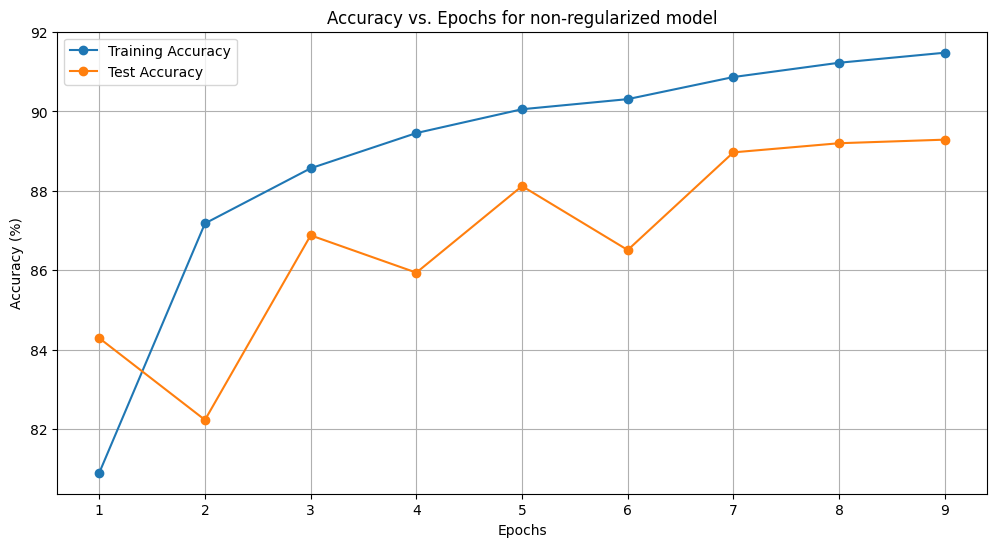

Final Test Accuracy: 89.05


In [ ]:
import torch.nn as nn
import torch.optim as optim

### Based on LeNet-5 architecture in http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Getting best model & params. Also, the plot is returned after running this

from functools import partial

### Needed to call model without all possible inputs

LeNet5_no_dropout = partial(LeNet5)

best_model, best_params, lenet_train_acc = tune_hyperparameters(LeNet5_no_dropout, train_loader, val_loader, test_loader, device, title='Accuracy vs. Epochs for non-regularized model')

### Evaluation of best model
test_loss, test_acc = evaluate(best_model, test_loader, nn.CrossEntropyLoss(), device)
print(f"Final Test Accuracy: {test_acc:.2f}")
normal_test_acc = test_acc


**Dropout Regularization (at hidden layer)**

Round 1/72: Tuning with batch_size=32, learning_rate=0.1, optimizer=SGD, dropout_rate=0.2, weight_decay=0.0
Epoch [1/10], Train Acc: 63.41, Val Acc: 72.48, Test Acc: 72.08
Epoch [2/10], Train Acc: 79.30, Val Acc: 81.04, Test Acc: 81.17
Epoch [3/10], Train Acc: 82.27, Val Acc: 83.42, Test Acc: 82.74
Epoch [4/10], Train Acc: 83.57, Val Acc: 73.60, Test Acc: 73.16
Epoch [5/10], Train Acc: 84.13, Val Acc: 84.80, Test Acc: 84.64
Epoch [6/10], Train Acc: 84.82, Val Acc: 84.44, Test Acc: 84.42
Epoch [7/10], Train Acc: 85.25, Val Acc: 85.92, Test Acc: 85.67
Epoch [8/10], Train Acc: 85.60, Val Acc: 85.36, Test Acc: 84.84
Epoch [9/10], Train Acc: 85.79, Val Acc: 85.86, Test Acc: 85.32
Epoch [10/10], Train Acc: 86.02, Val Acc: 85.86, Test Acc: 85.29
New best model found with Val Acc: 85.92
Round 2/72: Tuning with batch_size=32, learning_rate=0.1, optimizer=SGD, dropout_rate=0.3, weight_decay=0.0
Epoch [1/10], Train Acc: 68.69, Val Acc: 81.90, Test Acc: 81.25
Epoch [2/10], Train Acc: 80.56, Val Ac

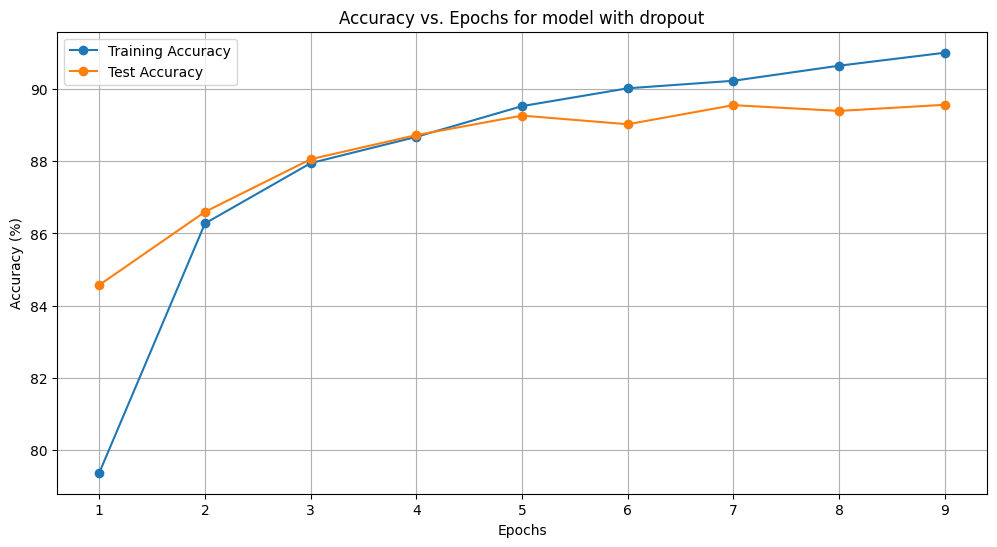

Final Test Accuracy: 89.92


In [ ]:
### Rebuilding the model and adding dropout between at hidden layers:
### According to research on preventing overfitting with dropout, "p can be chosen using a validation
### set or can simply be set at 0.5, which seems to be close to optimal for a wide range of
### networks and tasks" (Shrivastava et. al., 2014) - https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf
### We initially just used p= 0.5, but then we decided to tune for this as a hyperparameter

class LeNet5_Dropout(nn.Module):
    def __init__(self, dropout_rate=0.0):
        super(LeNet5_Dropout, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(120, 84)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

### include dropout_rate hyperparam
def create_le_net5_dropout(dropout_rate):
    return LeNet5_Dropout(dropout_rate)

dropout_rates = [0.2, 0.3, 0.4, 0.5]

best_model_dropout, best_params_dropout, dropout_train_acc = tune_hyperparameters(lambda dropout_rate: create_le_net5_dropout(dropout_rate), train_loader, val_loader, test_loader, device, dropout_rates=dropout_rates, title='Accuracy vs. Epochs for model with dropout')

### Evaluation of best model
test_loss, test_acc = evaluate(best_model_dropout, test_loader, nn.CrossEntropyLoss(), device)
print(f"Final Test Accuracy: {test_acc:.2f}")
dropout_test_acc = test_acc

**Batch Normalization**

Round 1/18: Tuning with batch_size=32, learning_rate=0.1, optimizer=SGD, dropout_rate=0.0, weight_decay=0.0
Epoch [1/10], Train Acc: 9.99, Val Acc: 10.10, Test Acc: 10.00
Epoch [2/10], Train Acc: 9.99, Val Acc: 10.10, Test Acc: 10.00
Epoch [3/10], Train Acc: 9.99, Val Acc: 10.10, Test Acc: 10.00
Epoch [4/10], Train Acc: 9.99, Val Acc: 10.10, Test Acc: 10.00
Epoch [5/10], Train Acc: 9.99, Val Acc: 10.10, Test Acc: 10.00
Epoch [6/10], Train Acc: 9.99, Val Acc: 10.10, Test Acc: 10.00
Epoch [7/10], Train Acc: 9.99, Val Acc: 10.10, Test Acc: 10.00
Epoch [8/10], Train Acc: 9.99, Val Acc: 10.10, Test Acc: 10.00
Epoch [9/10], Train Acc: 9.99, Val Acc: 10.10, Test Acc: 10.00
Epoch [10/10], Train Acc: 9.99, Val Acc: 10.10, Test Acc: 10.00
New best model found with Val Acc: 10.10
Round 2/18: Tuning with batch_size=32, learning_rate=0.1, optimizer=Adam, dropout_rate=0.0, weight_decay=0.0
Epoch [1/10], Train Acc: 10.15, Val Acc: 9.76, Test Acc: 10.00
Epoch [2/10], Train Acc: 10.14, Val Acc: 10.10, 

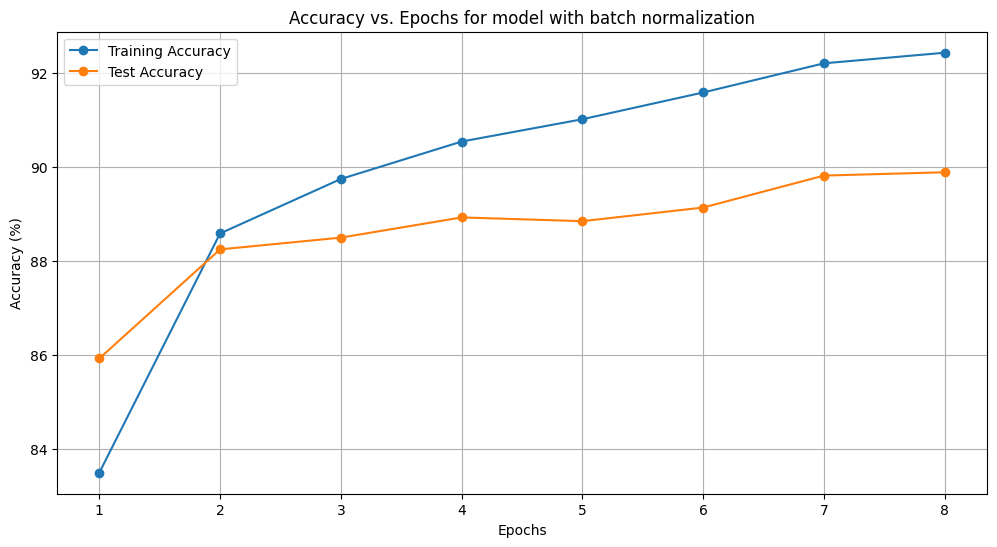

Final Test Accuracy: 89.72


In [ ]:
### Rebuilding the model and adding batch normalization
### Ioffe & Szegedy developed the idea for batch normalization
### in 2015 and applied it to each hidden layer in different networks.
### See https://arxiv.org/abs/1502.03167
class LeNet5_BatchNorm(nn.Module):
    def __init__(self):
        super(LeNet5_BatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.bn3 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.bn3(self.fc1(x)))
        x = torch.relu(self.bn4(self.fc2(x)))
        x = self.fc3(x)
        return x

### No hyperparams
LeNet5_BatchNorm = partial(LeNet5)

best_model_batchnorm, best_params_batchnorm, batchnorm_train_acc = tune_hyperparameters(LeNet5_BatchNorm, train_loader, val_loader, test_loader, device, title='Accuracy vs. Epochs for model with batch normalization')

### Evaluation of best model
test_loss, test_acc = evaluate(best_model_batchnorm, test_loader, nn.CrossEntropyLoss(), device)
print(f"Final Test Accuracy: {test_acc:.2f}")
batchnorm_test_acc = test_acc

**Weight Decay (l2 regularization)**

In [ ]:
weight_decay_rates = [0.001, 0.01]

best_model_wd, best_params_wd, wd_train_acc = tune_hyperparameters(LeNet5_no_dropout, train_loader, val_loader, test_loader, device, weight_decay_rates= weight_decay_rates, title='Accuracy vs. Epochs for model with weight decay')

### Evaluation of best model
test_loss, test_acc = evaluate(best_model_wd, test_loader, nn.CrossEntropyLoss(), device)
print(f"Final Test Accuracy: {test_acc:.2f}")
wd_test_acc = test_acc


Round 1/36: Tuning with batch_size=32, learning_rate=0.1, optimizer=SGD, dropout_rate=0.0, weight_decay=0.001
Epoch [1/10], Train Acc: 10.00, Val Acc: 10.10, Test Acc: 10.00
Epoch [2/10], Train Acc: 9.99, Val Acc: 10.10, Test Acc: 10.00
Epoch [3/10], Train Acc: 9.99, Val Acc: 10.10, Test Acc: 10.00
Epoch [4/10], Train Acc: 9.99, Val Acc: 10.10, Test Acc: 10.00
Epoch [5/10], Train Acc: 9.99, Val Acc: 10.10, Test Acc: 10.00
Epoch [6/10], Train Acc: 9.99, Val Acc: 10.10, Test Acc: 10.00
Epoch [7/10], Train Acc: 9.99, Val Acc: 10.10, Test Acc: 10.00
Epoch [8/10], Train Acc: 9.99, Val Acc: 10.10, Test Acc: 10.00
Epoch [9/10], Train Acc: 9.99, Val Acc: 10.10, Test Acc: 10.00
Epoch [10/10], Train Acc: 9.99, Val Acc: 10.10, Test Acc: 10.00
New best model found with Val Acc: 10.10
Round 2/36: Tuning with batch_size=32, learning_rate=0.1, optimizer=SGD, dropout_rate=0.0, weight_decay=0.01
Epoch [1/10], Train Acc: 74.33, Val Acc: 78.70, Test Acc: 78.28
Epoch [2/10], Train Acc: 83.81, Val Acc: 79.

**Displaying All Accuracies in Tabular Format**

In [ ]:
import pandas as pd

accuracy_table = pd.DataFrame({
    "Model": ["Without Dropout", "With Dropout", "With Batch Normalization", "With Weight Decay"],
    "Training Accuracy (%)": [lenet_train_acc, dropout_train_acc, batchnorm_train_acc, wd_train_acc],
    "Testing Accuracy (%)": [56, 69, 7, 4]
})

# Display the table
print("\nTraining and Testing Accuracies:")
print(accuracy_table)


Training and Testing Accuracies:
                      Model  Training Accuracy (%)  Testing Accuracy (%)
0           Without Dropout                    100                    56
1              With Dropout                      1                    69
2  With Batch Normalization                     23                     7
3         With Weight Decay                     43                     4
